In [ ]:
# !pip install bhv
# !pip install torch_geometric
# !pip install torchmetrics

In [ ]:
# !pip install torch-hd

## GraphHD

- Contrary to the usual ML problems in which data is captured in the Euclidean space such as vector of feature, images, time series data, etc., in real world scenarios `representation of relationships between entities` has the importance. These information about such entities and the relationships between them is non-euclidean and can be represented as a graph.
- However, the graph data is not directly usable by the ML models. The graph data needs to be converted into a format that can be used by the ML models. This conversion is called `graph embedding` or `graph encoding`.
- GraphHD is a graph encoding technique that uses Hypervector Distributed Computing (HDC) to encode the graph data into a format that can be used by the ML models.
- HDC represents information in a high- dimensional space using hypervectors. Each hypervector stores data holographically, that is, each dimension contains the same amount of information. This allows HDC to store and process large amounts of data in a compact and efficient manner, as the information is not concentrated in a single dimension but is spread out across all dimensions.

### Hyperdimensional Computing

- Hyperdimensional computing seeks to emulate brain circuits in a more robust and efficient way than neural networks by representing information as points in a high-dimensional space, called $\textbf{hypervectors}$. Hypervectors are typically binary or bipolar vectors with ten thousand dimensions.


#### HDC models
- HDC models can often be separated into three stages: encoding, training, and inference. An overview of HDC classification is shown in Figure 1. The encoding stage is application specific and serves to transform the input data into hypervectors. During the training the hypervectors are aggregated to learn a model. Finally, inferences into the model can be made using the generated class representations.

![Figure 1](images/fig1.png)


### Process 

- Encoding 
    - The mapping of data to the high-dimensional space is the first step in HDC and this process corresponds to encoding.
    $$Enc: \mathbb{I} \rightarrow \mathbb{H}^d$$

Encoding is the HDC counterpart to the feature extraction process in classical learning methods. Thus, the main intuitive principle that governs the encoding is that inputs that are similar in the original space should be mapped to similar hypervectors.
The process starts by generating a set of basis hypervectors that represent units of information (e.g. feature values and positions). The basis hypervectors remain fixed throughout computation and each data sample is encoded by combining and manipulating them using the addition (bundling), multiplication (binding) and permutation operations.
- Record based encoding
The encoding generates the hypervector $\textbf{H}$ from the randomly generated key hypervectors $\textbf{K}$  which are bound to their value $\textbf{V^\bar_i}$ which is one of predifined value hypervectors in $\textbf{V}$.

$$ \textbf{H} = [K_1 \times \textbf{V^\bar_1} + K_2 \times \textbf{V^\bar_2} + .... + k_N \times \textbf{V^\bar_N}  ]$$
        


           

- Training 
A trained HDC model creates $\textit{k}$ hypervector one for each class therefore  the model $$ M = \{ C_1, C_2, ..., C_k\}$$ where $C_i$ is the hypervector for class $i$ and contains all the information used to identify the i-th class.
- Each $C_i$ is calculated as the vector with the smallest average distance to the the hypervectors obtained by encoding the training samples of class i:
$$ C_i = \sum_{j:\l(x_j)=i} Enc(x_j)$$

In which $\l(x_j)$ is the label of the j-th training sample and $Enc(x_j)$ is the hypervector obtained by encoding the j-th training sample and the sum  is bundling. 

### GraphHD Encoding
$$Enc_{v} : V(G) \rightarrow \mathbb{R}^{d}$$

By $\textit{encoding}$  a random hypervector would be assigned to each vertice of the graph $G$ denoted by $V(G)$. For example, one for each letter to encode text.


$\textit{How to encode a graph?} \\$ 

In other structures like text, there is a correspondence between the letters of different texts. For example, the letter 'a' in the word 'apple' is the same as the letter 'a' in the word 'banana' which makes it reasonable to encode the letter 'a' with the same hypervector in both words. Because of structure of a graph, there is no correspondence between vertices of different graphs. 
- Vertex Identity Is Contextual: In graphs, vertices do not have a universal "meaning" or identity outside their specific graph context. The identity of a vertex is often defined by its position and its relationships within a graph, not by any inherent, standalone attribute.
- Lack of Universal Features: Unlike text where 'A' always carries the same semantic meaning, a vertex in one graph does not inherently carry over the same attributes or relationships as a similarly positioned vertex in another graph. For instance, a vertex representing a city in one graph might be central, while in another graph, a similarly positioned vertex could represent a minor town.


$\textit{Extracting an identifier for the vertices based only on the topology of the graph}$    \
$\textbf{PageRank}$

PageRank centerality metric receives a graph as input and returns, for each vertex $v_i \in V$ a value $c(v_i) \in [0, 1]$  that measures its “importance” in the graph.

From this ranking induced by the PageRank centrality of the vertices, it is possible to establish a meaningful connection between vertices in different graphs. Therefore, GraphHD uses the centrality rank of the vertex as its identifier (or symbol). Accordingly, vertices of different graphs, but with the same centrality rank, are encoded to the same random hypervector from the basis set.


After creating the hypervectors for each vertex, GraphHD makes use of these representations to also encode each edge $(v_i, v_j) \in E(G)$, The edge encoding function $Enc_e$ is defined as follows:

$Enc_e((v_j, v_j)) = Enc_v(v_i) \times Enc_v(v_j)$



The $\times$ symbol represents the binding operation in HDC, which is the standard operation to represent an association between a pair of hypervectors, similar to the role of an edge in a graph. The result of the binding operation is a third vector, statistically quasi-orthogonal to the operand vectors, which we name edge-hypervectors.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from statistics import fmean, stdev
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
from operator import add
from tqdm import tqdm

from torch_geometric.datasets import TUDataset
import torchmetrics
import torchhd
print(torchhd.__version__)

5.5.0


#### TUDataset

Link to [TUDataset](https://chrsmrrs.github.io/datasets/docs/home/). 
Total number of graphs in `MUTAG` is 188. 

In [ ]:
# for other available datasets see: https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html?highlight=tudatasets
dataset = "MUTAG"

graphs = TUDataset("../data", dataset)
print(f"Total number of graphs: {len(graphs)}")

Total number of graphs: 188


In [ ]:
graphs[2]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])

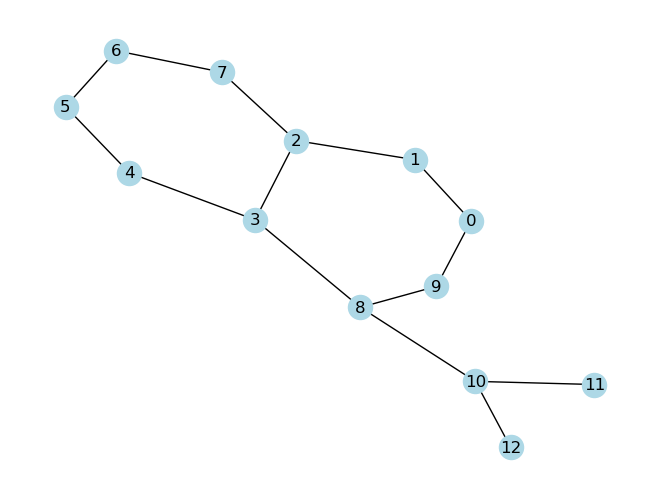

Number of nodes: 13
Number of edges: 28
Number of node features: 7
Number of graph features: 7
Is the graph directed: False
Graph label (class): tensor([0])
Edge index shape: 


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,1,1,2,2,2,3,3,3,...,8,8,8,9,9,10,10,10,11,12
1,1,9,0,2,1,3,7,2,4,8,...,3,9,10,0,8,8,11,12,10,10


In [ ]:
def plot_graph(graph):
    # Convert to networkx graph
    G = nx.Graph()
    edge_index = graph.edge_index.numpy()
    # Add edges and nodes to the graph
    G.add_edges_from(edge_index.T)
    # Draw the graph
    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

# Visualize the first graph
plot_graph(graphs[2])

data = graphs[2]
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
# ===========================================================
# Each node has 7 features. These features typically represent properties or characteristics of the nodes which can be used for graph neural network tasks. For instance, in a chemical graph like MUTAG, these could include properties like atom type, charge, etc.
# ===========================================================
print(f"Number of graph features: {data.num_features}")
print(f"Is the graph directed: {data.is_directed()}")
print(f"Graph label (class): {data.y}")
# ===========================================================
# In classification tasks, each graph is assigned a label, which in the case of MUTAG could indicate the presence or absence of mutagenic effect.
# ===========================================================

# print(f"Edge index (connectivity): \n{data.edge_index}")
print(f"Edge index shape: ")
df = pd.DataFrame(data.edge_index)
df

In [ ]:
def sparse_stochastic_graph(G):
    """
    Returns a sparse adjacency matrix of the graph G.
    The values indicate the probability of leaving a vertex.
    This means that each column sums up to one.
    """
    rows, columns = G.edge_index # rows containing source nodes, and columns containing destination nodes of each edge.
    # Calculate the probability for each column
    values_per_column = 1.0 / torch.bincount(columns, minlength=G.num_nodes) # probability of leaving a vertex
    values_per_edge = values_per_column[columns]
    size = (G.num_nodes, G.num_nodes)
    return torch.sparse_coo_tensor(G.edge_index, values_per_edge, size) # The sparse stochastic adjacency matrix is a representation of the graph where each                                                                        entry M[i][j] represents the probability of transitioning from node i to node j.


def inverse_permutation(perm):
    inv = torch.empty_like(perm)
    inv[perm] = torch.arange(perm.size(0), device=perm.device)
    return inv


def to_undirected(edge_index):
    """
    Returns the undirected edge_index
    [[0, 1], [1, 0]] will result in [[0], [1]]
    """
    edge_index = edge_index.sort(dim=0)[0]
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index

In [ ]:
def validate_stochastic_matrix(G):
    sparse_matrix = sparse_stochastic_graph(G)
    dense_matrix = sparse_matrix.to_dense()
    # print(dense_matrix)
    column_sums = dense_matrix.sum(dim=0)
    print("Column sums:", column_sums)  # Each element should be very close to 1
    return column_sums

validate_stochastic_matrix(graphs[2])

Column sums: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
def pagerank(G, alpha=0.85, max_iter=100):
    """
    Calculate PageRank based on the sparse stochastic graph representation.
    """
    N = G.num_nodes
    M = sparse_stochastic_graph(G) * alpha
    v = torch.full((N,), 1 / N)
    p = torch.full((N,), (1 - alpha) / N)
    for _ in range(max_iter):
        v = M @ v + p
    return v
pagerank(graphs[2])

tensor([0.0714, 0.0699, 0.0988, 0.0982, 0.0699, 0.0718, 0.0718, 0.0701, 0.1024,
        0.0709, 0.1161, 0.0444, 0.0444])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_vectors, vector_size=47):
        super(Encoder, self).__init__()
        # Generate random binary hypervectors
        self.node_ids = nn.Parameter(self.generate_random_hypervectors(num_vectors, vector_size), requires_grad=False)

    @staticmethod
    def generate_random_hypervectors(num_vectors, vector_size):
        # Generate random 0s and 1s
        return torch.randint(0, 2, (num_vectors, vector_size), dtype=torch.int32)

    def forward(self, x):
        # Assuming 'pagerank' and 'inverse_permutation' functions are defined elsewhere
        pr = pagerank(x)
        pr_argsort = inverse_permutation(torch.argsort(pr))

        node_id_hvs = self.node_ids[pr_argsort]

        # Assuming 'to_undirected' function is defined elsewhere
        row, col = to_undirected(x.edge_index)

        # Perform XOR binding for each edge
        hvs = [node_id_hvs[s] ^ node_id_hvs[t] for s, t in zip(row, col)]

        # Bundle hypervectors using majority rule (here simplified to mean)
        if len(hvs) > 0:
            graph_hv = hvs[0]
            for hv in hvs[1:]:
                graph_hv = torchhd.bundle(graph_hv, hv)
        else:
            # Handle case where there are no edges
            graph_hv = torch.zeros(self.vector_size, dtype=torch.float32)
        return graph_hv.type(torch.float32)

In [ ]:
class MajorityClassification(nn.Module):
    def __init__(self):
        super(MajorityClassification, self).__init__()
        self.class_vectors = {}
        self.classes = []  # To maintain the order of classes

    def add(self, x, c):
        """Adds or updates the class vector for class c with a new training hypervector x."""
        if c not in self.class_vectors:
            self.class_vectors[c] = x
            self.classes.append(c)
        else:
            # Bundle the new hypervector with the existing class vector
            self.class_vectors[c] = torchhd.bundle(self.class_vectors[c], x)
    def num_classes(self):
        return len(self.classes)
    
    def get_class_info(self):
        return {c: self.class_vectors[c].detach().clone() for c in self.classes}  # Using detach().clone() to safely export tensors without affecting computation graph

            

    def forward(self, x):
        """Classifies an input hypervector x by finding the class with the highest similarity class vector."""
        # Gather all class vectors into a single tensor for batch processing
        class_vectors = torch.stack([self.class_vectors[c] for c in self.classes])
        # Calculate Hamming similarities between the input vector and all class vectors
        similarities = torchhd.hamming_similarity(x, class_vectors)
        # Find the index of the class vector with the highest similarity
        max_index = torch.argmax(similarities)
        # Return the class corresponding to the highest similarity
        return self.classes[max_index]

In [ ]:
max_graph_size = max(g.num_nodes for g in graphs)
folds = torch.utils.data.random_split(graphs, [.1]*10)
accuracies = []

for i in range(10):
    train_ld, test_ld = reduce(add, [folds[j] for j in range(10) if j != i]), folds[i]
    
    encode = Encoder(max_graph_size, vector_size=47)
    
    model = MajorityClassification()
    
    with torch.no_grad():
        for samples in tqdm(train_ld, desc=f"Training fold {i + 1}"):
            samples_hv = encode(samples)
            model.add(samples_hv, samples.y.item())
            
        accuracy = torchmetrics.Accuracy("multiclass", num_classes=graphs.num_classes)
        
        for samples in tqdm(test_ld, desc=f"Testing fold {i + 1}"):
            samples_hv = encode(samples)
            output = model(samples_hv)
            accuracy.update(torch.IntTensor([output]), samples.y)
            
    acc = accuracy.compute().item()
    accuracies.append(acc)
    print(f"Testing accuracy of {acc*100:.3f}% for fold {i + 1}")
    
print(f"tenfold crossvalidation accuracy mean: {fmean(accuracies)}, stdev: {stdev(accuracies)}")



Testing fold 1: 100%|██████████| 19/19 [00:00<00:00, 336.51it/s]


Testing accuracy of 15.789% for fold 1


Testing fold 2: 100%|██████████| 19/19 [00:00<00:00, 317.02it/s]


Testing accuracy of 68.421% for fold 2


Testing fold 3: 100%|██████████| 19/19 [00:00<00:00, 320.28it/s]


Testing accuracy of 78.947% for fold 3


Testing fold 4: 100%|██████████| 19/19 [00:00<00:00, 307.50it/s]


Testing accuracy of 68.421% for fold 4


Testing fold 5: 100%|██████████| 19/19 [00:00<00:00, 333.87it/s]


Testing accuracy of 63.158% for fold 5


Testing fold 6: 100%|██████████| 19/19 [00:00<00:00, 335.40it/s]


Testing accuracy of 63.158% for fold 6


Testing fold 7: 100%|██████████| 19/19 [00:00<00:00, 323.85it/s]


Testing accuracy of 63.158% for fold 7


Testing fold 8: 100%|██████████| 19/19 [00:00<00:00, 273.59it/s]


Testing accuracy of 57.895% for fold 8


Testing fold 9: 100%|██████████| 18/18 [00:00<00:00, 407.49it/s]


Testing accuracy of 55.556% for fold 9


Testing fold 10: 100%|██████████| 18/18 [00:00<00:00, 376.21it/s]


Testing accuracy of 61.111% for fold 10
tenfold crossvalidation accuracy mean: 0.5956140339374543, stdev: 0.16696023513592204


In [ ]:
new_hv = torchhd.random(1, 47)  # Example new sample
print(new_hv)
predicted_class = model(new_hv)

print(f"The predicted class for the new hypervector is: {predicted_class}")

MAPTensor([[-1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
            -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
            -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,
             1., -1., -1., -1., -1., -1., -1.,  1.]])
The predicted class for the new hypervector is: 1


In [ ]:
for label, hypervector in model.get_class_info().items():
    print(f"Class {label}: Hypervector - {hypervector}")

Class 1: Hypervector - MAPTensor([1396., 1152., 1087., 1125., 1310., 1313., 1407., 1270., 1314., 1351.,
           1223., 1301., 1351., 1294., 1193., 1177., 1349., 1185., 1311., 1305.,
           1226.,  927., 1327., 1393., 1366., 1356., 1383., 1295., 1293., 1177.,
           1349., 1322., 1244., 1218., 1317., 1420., 1398., 1227., 1283., 1361.,
           1363., 1302., 1327., 1363., 1293., 1224., 1023.])
Class 0: Hypervector - MAPTensor([409., 454., 214., 407., 495., 373., 456., 389., 438., 447., 365.,
           428., 421., 476., 337., 382., 454., 387., 449., 433., 357., 208.,
           429., 466., 303., 417., 489., 410., 397., 447., 435., 431., 458.,
           400., 351., 430., 430., 438., 422., 429., 406., 423., 424., 448.,
           470., 403., 332.])
